# Import File

In [112]:
from google.colab import files
uploaded = files.upload()

Saving archive (9).zip to archive (9) (3).zip


In [113]:
import zipfile
import os

with zipfile.ZipFile("archive (9).zip", "r") as zip_ref:
    zip_ref.extractall(".")

# Cek hasil ekstraksi
os.listdir()


['.config',
 'Notebook Outputs',
 'hymenoptera_data',
 'archive (9) (3).zip',
 'archive (9).zip',
 'archive (9) (2).zip',
 'archive (9) (1).zip',
 'sample_data']

# Library

In [122]:
# import tensorflow as tf
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
import matplotlib.pyplot as plt

# Preprocess


In [126]:
# menentukan lokasi dataset
train_dir = "hymenoptera_data/train"
val_dir = "hymenoptera_data/val"

# mmebuat dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),
    batch_size=32
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=(224, 224),
    batch_size=32
)

# Normalisasi
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))


Found 245 files belonging to 2 classes.
Found 153 files belonging to 2 classes.


In [127]:
''' data augmentation
menambah variasi gambar secara acak, bertujuan untuk menghindari overhitting dam memperkaya data pelatihan.'''
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create a data generator
datagen_train = ImageDataGenerator(
    samplewise_center=True,  # set each sample mean to 0
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.1,  # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False,
)

# No need to augment validation data
datagen_valid = ImageDataGenerator(samplewise_center=True)

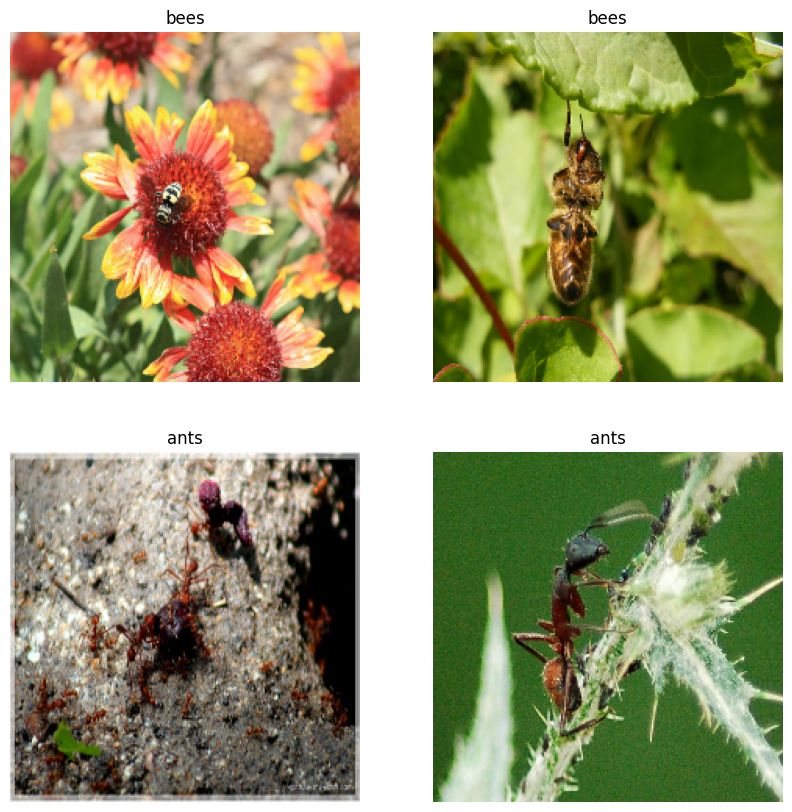

In [128]:
plt.figure(figsize=(10, 10))
class_names = ['ants', 'bees']

for images, labels in train_ds.take(1):
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(images[i])  # tanpa astype("uint8")
        plt.title(class_names[labels[i].numpy()])
        plt.axis("off")


#CNN

In [129]:
# classic CNN
model_cnn = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')

    # dense layers
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

model_cnn.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_cnn = model_cnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15
)

# model CNN ini digunakan karena, model dapat mengenali pola visual tanpa perlu ditentukan manual. model ini juga cenderung lebih sederhana dan cocok untuk data yang kecil.

SyntaxError: invalid syntax. Perhaps you forgot a comma? (ipython-input-747781859.py, line 15)

In [ ]:
# --- Classification Report ---
# Prediksi label pada validation dataset
y_pred_probs = model_cnn.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Label sebenarnya
y_true = np.concatenate([y for x, y in val_ds], axis=0)

# Laporan klasifikasi
print("\n=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=val_ds.class_names))

In [ ]:
from sklearn.metrics import roc_curve, auc, classification_report
import matplotlib.pyplot as plt
import numpy as np

# --- Prediksi dan label ---
y_pred_probs = model_cnn.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.concatenate([y for x, y in val_ds], axis=0)

# --- Classification Report ---
print("\n=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=val_ds.class_names))

# --- ROC Curve & AUC ---
# Ambil probabilitas untuk kelas positif (misalnya kelas index 1)
y_prob = y_pred_probs[:, 1]

# Hitung ROC dan AUC
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

# --- Plot ROC Curve ---
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - CNN Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# --- Prediksi dan label ---
y_pred_probs = model_cnn.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.concatenate([y for x, y in val_ds], axis=0)

# --- Classification Report ---
print("\n=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=val_ds.class_names))

# --- ROC Curve & AUC ---
# Gunakan probabilitas kelas positif (misalnya index 1)
y_prob = y_pred_probs[:, 1]

fpr, tpr, thresholds = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - CNN Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# --- Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_ds.class_names)

plt.figure(figsize=(5,5))
disp.plot(cmap='Blues', values_format='d')_


In [ ]:
def plot_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title(f'{title} - Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(f'{title} - Loss')
    plt.legend()

    plt.show()

plot_history(history_cnn, "Simple CNN")

berdasarkan hasil analysis di dapati bahwa, model CNN yang digunakan tidak belajar dengan baik. garis biru (training accuracy) terus meningkat dari 0.5 sampai 1, hal ini menandakan bahwa model sangat bagus dalam mentraining data. namun garis merah (validation accuracy) stuck diantara 0.6 sampai 0.7 (tidak stabil). artinya model hanya mengahafal data (overhitting) dan gagal mengenali pla pada data baru.

pada grafik loss. garis biru (training loss) terus menurun hingga mendekati 0, artinya model semakin yakin dengan hasil data yang dilatih. namun garis merah (validation loss) malah semakin meningkat. artinya model semakin yakin terhadap prediksi-nya, namun sebenarnya presdiksinya salah. model tidak memiliki kemampuan untuk beradaptasi dengan data baru.

In [ ]:
# MobileNetV2
base_model = MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False

model_mobilenet = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='softmax')
])

model_mobilenet.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_mobilenet = model_mobilenet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

# MobileNetV2 adalah model CNN pre-trained yang sudah dilatih di dataset besar ikagenet, sehingga sudah belajar banyak pola visual umum, model ini bisa dijadikan 'basis' untuk model baru yang punya dataset yang kecil.


In [ ]:
# Unfreeze sebagian layer
base_model.trainable = True

# Lock hanya layer awal
for layer in base_model.layers[:100]:
    layer.trainable = False

# Compile ulang
model_mobilenet.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

fine_tune_history = model_mobilenet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)


In [ ]:
# --- Prediksi dan label aktual ---
y_pred_probs = model_mobilenet.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.concatenate([y for x, y in val_ds], axis=0)

# --- Classification Report ---
print("\n=== Classification Report (MobileNetV2) ===")
print(classification_report(y_true, y_pred, target_names=val_ds.class_names))

In [ ]:
# --- ROC Curve & AUC ---
# Gunakan probabilitas kelas positif (misalnya index 1)
y_prob = y_pred_probs[:, 1]

fpr, tpr, thresholds = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - MobileNetV2')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
# --- Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_ds.class_names)

plt.figure(figsize=(5,5))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - MobileNetV2')
plt.show()

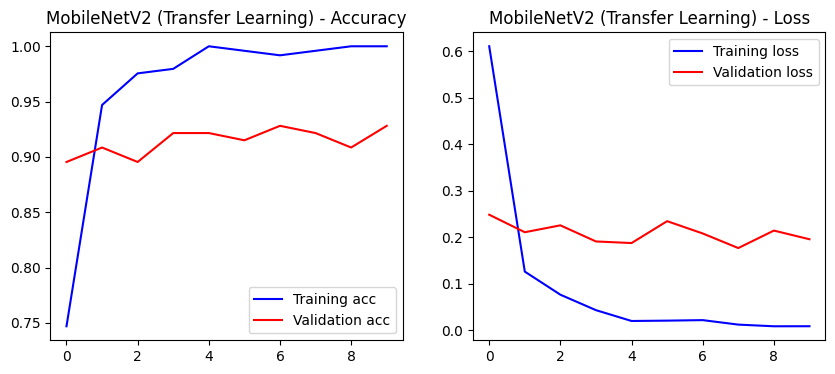

In [130]:
plot_history(history_mobilenet, "MobileNetV2 (Transfer Learning)")


In [131]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Prediksi model
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred_cnn = np.argmax(model_cnn.predict(test_ds), axis=1)
y_pred_mobile = np.argmax(model_mobilenet.predict(test_ds), axis=1)

# Confusion Matrix Classic CNN
cm_cnn = confusion_matrix(y_true, y_pred_cnn)
disp_cnn = ConfusionMatrixDisplay(confusion_matrix=cm_cnn)
disp_cnn.plot(cmap='viridis')
plt.title("Classic CNN Confusion Matrix")
plt.show()

# Confusion Matrix MobileNetV2
cm_mobile = confusion_matrix(y_true, y_pred_mobile)
disp_mobile = ConfusionMatrixDisplay(confusion_matrix=cm_mobile)
disp_mobile.plot(cmap='viridis')
plt.title("MobileNetV2 Confusion Matrix")
plt.show()


NameError: name 'test_ds' is not defined

berdasarkan graf yang dihasilkan, didapati bahwa model ini juga tidak belajar dengan baik.

pada graf akurasi garis biru (training accuracy) kenaikan nya sangat drastis dari 0.825 bisa melonjak ke 1 artinya model benar benar menghafal. garis merah (validation accuracy) berada di antara 0.92 sampai 0.93, cenderung tidak ada peningkatan seiring dengan bertambahnya epoch. hal ini menandakan bahwa model toda belajar secara general dan hanya menghafal model, sehingga tidak bisa memprediksi model baru.

graf loss
garis biru (training loss) mengalami penurunan dari 0.4 ke sekitar 0.05 hal ini menandakan bahwa model semakin baik dalam mempelajari data, model mampu meminimalkan error. dan garis merah (validationloss) berada di kisaran 0.17 sampai 0.25. menandakan bahwa kemampuan model dalam menggeneralisasi ke data baru tidak meningkat secara signifikan. hal ini menjadi tanda bahwa model overhitting.

# kesimpulan
model yang dilatih overhitting sehingga hasil prediksi yang di dapatkan kurang maksimal. model hanya menghafal data training dan tidak bisa memprediksi model baru. meskipun begitu model CNN menggunakan MobileNet dapat dikatakan sedikit lebih baik dibandingkan dengan menggunakna model CNN biasa. karena mobilenet memiliki akurasi yang lebih tinggi, artinya model lebih mampu mengenali data baru, dan loss nya lebih stabil. tapi perlu diingat bahwa model dengan mobilenet ini juga belum menghasilakn hasil yang maksimal, model masih overfit.